In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import math
import json
import istarmap  # import to apply monkey patch
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats 
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler, RobustScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

from aggregators import bucket_and_bin

In [3]:
# ouputs
fn_distance = '../data/output/figs/fig2_dist.csv'
fn_t_test = '../data/output/tables/table1_cities_ranked_by_categories.csv'
fn_regression_all = '../data/output/tables/table2_regression_outputs_all.csv'
fn_regression_income = '../data/output/tables/table3a_regression_outputs_income.csv'
fn_regression_race = '../data/output/tables/table3b_regression_outputs_race.csv'
fn_regression_redlining = '../data/output/tables/table3c_regression_outputs_redlining.csv'


fn_observed_income = '../data/output/figs/fig4_income.csv'
fn_adjusted_income = '../data/output/figs/fig5_income.csv'
fn_observed_race = '../data/output/figs/fig4_race.csv'
fn_adjusted_race= '../data/output/figs/fig5_race.csv'
fn_observed_redlining = '../data/output/figs/fig4_redlining.csv'
fn_adjusted_redlining = '../data/output/figs/fig5_redlining.csv'

# inputs
fn_att = '../data/output/speed_price_att.csv.gz'
fn_centurylink = '../data/output/speed_price_centurylink.csv.gz'
fn_verizon = '../data/output/speed_price_verizon.csv.gz'
fn_earthlink = '../data/output/speed_price_earthlink.csv.gz'
inputs = {
    "AT&T" : fn_att,
    "CenturyLink": fn_centurylink,
    "Verizon": fn_verizon,
    "EarthLink" : fn_earthlink
}

# params
recalculate = False
threshold = 0.05
n_jobs = 20

In [4]:
c = 0
for fn in inputs.values():
    d = pd.read_csv(fn, compression='gzip')
    d = len(d[d.speed_down != 0])
    print(fn, d)
    c += d
c

/home/chino/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


../data/output/speed_price_att.csv.gz 356051
../data/output/speed_price_centurylink.csv.gz 180067


/home/chino/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


../data/output/speed_price_verizon.csv.gz 224149
../data/output/speed_price_earthlink.csv.gz 399073


1159340

## Median Distance

In [5]:
isp2house = {
    'Verizon': '../data/output/figs/house_emoji_brick.png',
    'AT&T': '../data/output/figs/house_emoji.png',
    'CenturyLink': '../data/output/figs/house_emoji_blue.png'
}

In [6]:
cols = [
    'address_full',
    'lat', 'lon',
    'race_perc_non_white',
    'n_providers',
    'median_household_income',
    'redlining_grade'
]
def plot_distance_to_fiber(slow_to_blazin, isp):
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label, markerfacecolor="#1f66e0", markersize=10)
                   for label, c in isp2house.items()][::-1]
    slow_to_blazin.major_city = slow_to_blazin.major_city.apply(lambda x: x.title())
    to_plot = slow_to_blazin.groupby(['major_city', 'state', 'isp']).closest_fiber_miles.median().sort_values(ascending=True)
    to_plot = (to_plot * 1609.34).reset_index()
    to_plot['zeros'] = 0
    print(to_plot.head(3))
    title = f"Median Distance Between Households {isp}\nOffered Slow Speeds and Blazin' Fiber Speeds"
    ax = to_plot.plot(x = 'closest_fiber_miles', y='major_city', kind='scatter',
                 s= 90, color ='#4385f2', figsize=(6, 10),
                 title=title)
    to_plot.plot(x = 'closest_fiber_miles', y='major_city', kind='scatter',
                 s= 20, color ='white', ax=ax)
    for i, (_, row) in enumerate(to_plot.iterrows()):
        x = row['closest_fiber_miles']
        fn_image = isp2house.get(row['isp'])
        image = OffsetImage(plt.imread(fn_image), zoom=.035)
        ab = AnnotationBbox(image, (x, i), frameon=False)
        ax.add_artist(ab)
    
    x1 = np.zeros(len(to_plot)).tolist()
    x2 = to_plot['closest_fiber_miles'].tolist()
    n = to_plot['major_city'].tolist()
    for i in range(0, len(x1)):
        plt.plot([x1[i], x2[i]], [n[i], n[i]], '-', color='#4385f2', lw=4, zorder=-1)

    # Hide the right and top spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(left=0)
    labels = ax.get_xticks().tolist()
    labels = [int(_) for _ in labels]
    labels[0] = "0 meters"
    ax.set_xticklabels(labels)
    
    plt.gca().invert_yaxis()

    ax.set_xlabel("")
    ax.set_ylabel("")
#     ax.get_legend().remove()
    
    ax.grid(axis='x', zorder=0)
    ax.set_ylim(top=n[0], bottom=n[-1])
    plt.show()

In [7]:
def filter_df(fn, isp):
    """
    Filters out no service offers 
    """
    df = pd.read_csv(fn)
    df = df[df.speed_down != 0]
    df = bucket_and_bin(df)
    df['isp'] = isp
    if isp == 'Verizon':
        df.price = df.price.replace({40: 39.99, 49.99: 39.99})
        df = df[df.price == 39.99]
        nyc_cities = ['new york', 'brooklyn', 'queens', 'staten island', 'brooklyn', 'bronx']
        nyc = []
        for city, _df in df.groupby('major_city'):
            if city in nyc_cities:
                nyc.extend(_df.to_dict(orient='records'))
        nyc = pd.DataFrame(nyc)
        nyc['major_city'] = 'new york city'
        
        # add NYC
        df = df[~df.major_city.isin(nyc_cities)]
        df = df.append(nyc)
        
    elif isp == 'EarthLink':
        df = df[df.contract_provider.isin(['AT&T', 'CenturyLink'])]
    return df

In [8]:
slows_to_blazins = pd.DataFrame([])
for isp, fn in inputs.items():
    if isp == 'EarthLink': continue
    df = filter_df(fn, isp)
    for city, _df in df.groupby(['major_city']):
        n_slow = len(_df[_df.speed_down_bins == 'Slow (<25 Mbps)'])
        n_not_slow = len(_df[_df.speed_down_bins != 'Slow (<25 Mbps)'])
        n_all = len(_df)
        if (_df.speed_down_bins.nunique() <= 1) or (n_slow / n_all <= .01) or (n_not_slow / n_all <= .01):
            continue
        slow_to_blazin = _df[(_df.closest_fiber_miles != 0) & 
                            (_df.speed_down <= 25)]
        slows_to_blazins = slows_to_blazins.append(slow_to_blazin)

<ipython-input-8-d3891d53ddcc>:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  df = filter_df(fn, isp)
<ipython-input-8-d3891d53ddcc>:4: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  df = filter_df(fn, isp)


     major_city state      isp  closest_fiber_miles  zeros
0  Philadelphia    PA  Verizon            35.585935      0
1        Boston    MA  Verizon            53.643582      0
2    Washington    DC  Verizon            75.804138      0


<ipython-input-6-3194b9122f6e>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


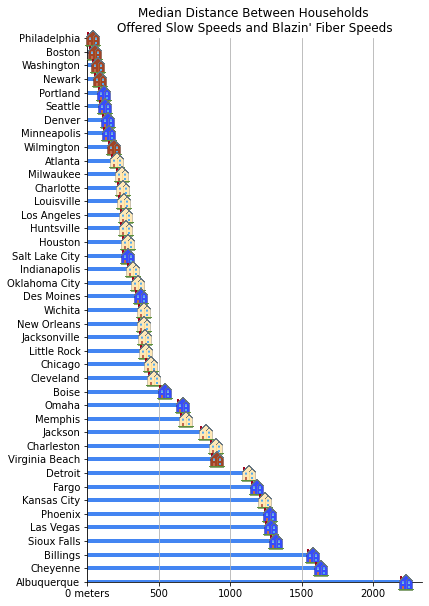

In [9]:
plot_distance_to_fiber(slows_to_blazins, isp="")

In [10]:
dist_summary = slows_to_blazins.groupby(['major_city', 'state', 'isp']).closest_fiber_miles.median().sort_values(ascending=True)

In [11]:
dist_summary.to_csv(fn_distance)

In [12]:
slows_to_blazins.groupby('isp').closest_fiber_miles.median().sort_values(ascending=True)* 1609.34

isp
Verizon        124.110743
AT&T           411.419143
CenturyLink    659.793897
Name: closest_fiber_miles, dtype: float64

In [13]:
dist_summary * 1609.34

major_city      state  isp        
Philadelphia    PA     Verizon          35.585935
Boston          MA     Verizon          53.643582
Washington      DC     Verizon          75.804138
Newark          NJ     Verizon          87.506333
Portland        OR     CenturyLink     117.594082
Seattle         WA     CenturyLink     121.755967
Denver          CO     CenturyLink     146.930425
Minneapolis     MN     CenturyLink     148.974406
Wilmington      DE     Verizon         188.670832
Atlanta         GA     AT&T            206.139991
Milwaukee       WI     AT&T            239.148902
Charlotte       NC     AT&T            246.165900
Louisville      KY     AT&T            257.894626
Los Angeles     CA     AT&T            269.980644
Huntsville      AL     AT&T            270.237510
Houston         TX     AT&T            281.306554
Salt Lake City  UT     CenturyLink     283.378684
Indianapolis    IN     AT&T            319.762967
Oklahoma City   OK     AT&T            356.592321
Des Moines     

In [14]:
def which_has_largest_proportion(df, col='income_level', bins=['Low'], comparison=[]):
    sample1 = df[df[col].isin(bins)]
    if len(comparison) != 0:
        sample2 = df[df[col].isin(comparison)]
    else:
        sample2 = df[~df[col].isin(bins)]
    try:
        prop1 = len(sample1[sample1.is_slow == 1]) / len(sample1)
        prop2 = len(sample2[sample2.is_slow == 1]) / len(sample2)
        return prop1, prop2, prop1 > prop2
    except Exception as e:
        print(e, df.head(2))
        return None, None, None

def t_test(df, col='income_level', bins=['Low'], comparison=[]):
    """ 
    If `comparison` is not set, the group within `bins` is compared to all others
    """
    df = df[~df[col].isnull()]
    sample1 = df[df[col].isin(bins)].is_slow
    if len(comparison) != 0:
        sample2 = df[df[col].isin(comparison)].is_slow
    else:
        sample2 = df[~df[col].isin(bins)].is_slow
    
    return stats.ttest_ind(a=sample1, b=sample2,  equal_var=False)

def confidence_interval_two_proportions(x1: pd.Series, 
                                        x2: pd.Series, 
                                        z: float =1.96) -> float:
    """
    Gets confidence interval between two proprotions.
    `x1` and `x2` should be boolean Series.
    `z` is the z-value, the default is for 95% confidence.
    See: https://online.stat.psu.edu/stat100/lesson/9/9.3
    """
    n1 = len(x1)
    n2 = len(x2)
    
    if n1 == 0 or n2 == 0:
        return None
    
    mean1 = x1.mean()
    mean2 = x2.mean()
    sem1 = math.sqrt((mean1 * (1 - mean1)) / n1)
    sem2 = math.sqrt((mean2 * (1 - mean2)) / n2)
    sed = math.sqrt(sem1 ** 2 + sem2 ** 2)
    
    return z * sed

def ci(df, col='income_level', bins=['Low'], comparison=[]):
    df = df[~df[col].isnull()]
    sample1 = df[df[col].isin(bins)].is_slow
    if len(comparison) != 0:
        sample2 = df[df[col].isin(comparison)].is_slow
    else:
        sample2 = df[~df[col].isin(bins)].is_slow
    
    return confidence_interval_two_proportions(sample1, sample2)

def t_test_flow(df, params):
    iv = params['iv']
    data = []
    for (city, state), _df in df.groupby(['major_city', 'state']):
        n_slow = len(_df[_df.is_slow == True])
        n_not_slow = len(_df[_df.is_slow == False])
        n_all = len(_df)
        if (_df.speed_down_bins.nunique() <= 1) or (n_slow / n_all <= .01) or (n_not_slow / n_all <= .01):
            # skip cities with homogenous speed (this is just for EarthLink and Verizon)
            data.append({'major_city': city, 'state': state, 'isp': isp})
            continue
        if iv == 'income':
            a, b, is_larger = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                           comparison=params['comparison'])

        elif iv == 'redlining':
            _df_rated = _df[~_df.redlining_grade.isnull()]
            if len(_df_rated) / n_all <= .05:
                data.append({'major_city': city, 'state': state, 'isp': isp})
                continue
            a, b, is_larger = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                           comparison=params['comparison'])
        elif iv == 'race':
            n_minority_white = len(_df[_df.race_perc_non_white > .5])            
            # check only cities with at least 5 percent of addresses in minority white.
            if n_minority_white / n_all <= .05:
                data.append({'major_city': city, 'state': state,'isp': isp})
                continue
            a, b, is_larger = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                          comparison=params['comparison'])
        pvalue = t_test(_df, col=params['col'], bins=params['grades'], comparison=params['comparison']).pvalue
        confidence_interval = ci(_df, col=params['col'], bins=params['grades'], comparison=params['comparison'])
        data.append({
            'major_city': city,
            'state': state,
            f'slowest_{iv}' : is_larger,
            f'p_value_{iv}' : pvalue,
            'isp': isp,
            f'prop_slow_{iv}_exposure': a,
            f'prop_slow_{iv}_treatment': b,
            f'prop_slow_{iv}_delta' : a-b if a else None,
            f'prop_slow_{iv}_ci': confidence_interval,
        })
        
    return data

In [15]:
income_params = {'iv': "income", 'grades': ['Low'], 'col': 'income_level'}
race_params = {'iv': "race", 'grades': ['least white'], 'col': 'race_quantile'}
redlining_params = {'iv': "redlining", 'grades': ['D'], 'col': 'redlining_grade'}

# Treatment group
income_params['comparison'] = ['Upper Income']
race_params['comparison'] = ['most white']
redlining_params['comparison'] = ['A', 'B']

In [16]:
if not os.path.exists(fn_t_test) or recalculate:
    table = pd.DataFrame()
    for isp, fn in tqdm(inputs.items()):
        df = filter_df(fn, isp)
        income_data = t_test_flow(df, params=income_params)
        race_data = t_test_flow(df, params=race_params)
        redlining_data = t_test_flow(df, params=redlining_params)

        df_table = pd.DataFrame(income_data).merge(
            pd.DataFrame(race_data), on=['major_city', 'isp', 'state'], how='outer'
        ).merge(
            pd.DataFrame(redlining_data), on=['major_city', 'isp', 'state'], how='outer'
        )

        table = table.append(df_table)
    table.major_city = table.major_city.str.title()
    table.to_csv(fn_t_test, index=False)

else:
    table = pd.read_csv(fn_t_test)

In [17]:
# all states in the study
table.state.nunique()

45

In [18]:
trend = set(table[(table.slowest_income == True) | 
      (table.slowest_race == True) | 
      (table.slowest_redlining == True)].major_city.unique())

reverse_trend = set(table[(table.slowest_income == False) & 
      (table.slowest_race == False) & 
      (table.slowest_redlining == False)].major_city.unique())

In [19]:
cities_with_pattern = set(table[(table.p_value_income < threshold) |
         (table.p_value_race < threshold) |
         (table.p_value_redlining < threshold)
         ].major_city.unique())

In [20]:
len(cities_with_pattern)

41

In [21]:
# how many cities exhibit none of these trends?
cities_with_pattern - trend

set()

In [22]:
random.seed(303)
p_value_threshold = 0.05
summary_data = []
for isp in inputs.keys():
    table_ = table[table.isp == isp]
    display(Markdown(f"{isp} was significantly more likely to offer slow speeds in..."))
    
    if isp == 'EarthLink':
        table_['major_city'] = table_.apply(lambda x: f"{x['major_city']} ({x['state'].upper()})", axis=1)
        
    null_cities = table_[(table_.slowest_income.isnull()) | (table_.prop_slow_income_treatment == 0)].major_city.unique()
    all_cities = table_.major_city.nunique()
    all_cities -= len(null_cities)
    
    # income
    n_cities = table_[~table_.slowest_income.isnull()].major_city.nunique()
    cities = table_[(table_.slowest_income == True) & 
                   (table_.p_value_income <= p_value_threshold)].major_city.unique()
    non_sig_cities = table_[table_.p_value_income > p_value_threshold].major_city.unique()
    sig_opposite_cities = table_[(table_.slowest_income == False) & 
                                 (table_.p_value_income <= p_value_threshold)].major_city.unique()
    
    random.shuffle(cities)
    n_low = len(cities)
    
    record_income ={
        'isp': isp,
        'null_cities' : null_cities.tolist(),
        'all_cities' : all_cities,
        'income_cities' : table_[~table_.slowest_income.isnull()].major_city.nunique(),
        'income_percent_low_income': round(n_low / n_cities * 100, 1),
        'income_cities_significant': cities.tolist(),
        'income_cities_non_significant' : non_sig_cities.tolist(),
        'income_cities_non_significant_anti_trend': sig_opposite_cities.tolist()
    }
    
    text =  (
        f"- {' and '.join(income_params['grades'])} Income areas than Upper Income areas in **{round(n_low / n_cities * 100, 1)}**% of cities ({n_low})."
        f"<br>This includes cities like {cities[0].title()}, {cities[1].title()}, and {cities[2].title()}."
    )
    if len(sig_opposite_cities) > 0:
        perc = round(len(sig_opposite_cities) / n_cities * 100, 1)
        text += f"<br>The opposite trend was statistically significant in {perc}% of cities ({len(sig_opposite_cities)})."
    
    if len(non_sig_cities) > 0:
        perc = round(len(non_sig_cities) / n_cities * 100, 1)
        text += f"<br>We found nonsignificant differences in {perc}% of cities ({len(non_sig_cities)})."
    display(Markdown(text))

    # race
    n_cities = table_[~table_.slowest_race.isnull()].major_city.nunique()
    random.shuffle(cities)
    cities = table_[(table_.slowest_race == True) & 
                    (table_.p_value_race <= p_value_threshold)].major_city.unique()
    
    non_sig_cities = table_[table_.p_value_race > p_value_threshold].major_city.unique()
    sig_opposite_cities = table_[(table_.slowest_race == False) & 
                                 (table_.p_value_race <= p_value_threshold)].major_city.unique()
    
    random.shuffle(cities)
    n_minority_white = len(cities)
    
    record_race ={
        'isp': isp,
        'race_cities' : table_[~table_.slowest_race.isnull()].major_city.unique().tolist(),
        'race_percent_low_income': round(n_minority_white / n_cities * 100, 1),
        'race_cities_significant': cities.tolist(),
        'race_cities_non_significant' : non_sig_cities.tolist(),
        'race_cities_non_significant_anti_trend': sig_opposite_cities.tolist()
    }
    
    text = (
        f"- the {' and '.join(race_params['grades'])} areas compared to the most white areas in <b>{round(n_minority_white / n_cities * 100, 1)}</b>% of cities ({n_minority_white})."
        f"<br>This includes cities like {', '.join([c.title() for c in cities[:3]])}.\n"
    )
    if len(sig_opposite_cities) > 0:
        perc = round(len(sig_opposite_cities) / n_cities * 100, 1)
        text += f"<br>The opposite trend was statistically significant in {perc}% of cities ({len(sig_opposite_cities)})."
    
    if len(non_sig_cities) > 0:
        perc = round(len(non_sig_cities) / n_cities * 100, 1)
        text += f"<br>We found nonsignificant differences in {perc}% of cities ({len(non_sig_cities)})."
    
    if n_cities < all_cities:
        diff = all_cities - n_cities
        record_race['race_n_cities_cant_analyze'] = diff
        text += f"<br>We exclude {diff} {'cities' if diff > 1 else 'city'} for not containing enough minority white areas for comparison."
    display(Markdown(text))

    # redlining
    n_cities = table_[~table_.slowest_redlining.isnull()].major_city.nunique()
    cities = table_[(table_.slowest_redlining == True) & 
                    (table_.p_value_redlining <= p_value_threshold)].major_city.unique()
    non_sig_cities = table_[table_.p_value_redlining > p_value_threshold].major_city.unique()
    sig_opposite_cities = table_[(table_.slowest_redlining == False) & 
                                 (table_.p_value_redlining <= p_value_threshold)].major_city.unique()
    
    random.shuffle(cities)
    n_redline = len(cities)
    
    record_redlining ={
        'isp': isp,
        'redline_cities' : table_[~table_.slowest_redlining.isnull()].major_city.unique().tolist(),
        'redline_percent_low_income': round(n_redline / n_cities * 100, 1),
        'redline_cities_significant': cities.tolist(),
        'redline_cities_non_significant' : non_sig_cities.tolist(),
        'redline_cities_non_significant_anti_trend': sig_opposite_cities.tolist()
    }
    summary_data.append({**record_income, **record_race, **record_redlining})
    
    if len(cities) >= 3:
        text = (
            f"- {' and '.join(redlining_params['grades'])}"
            f" graded areas than A and B graded areas in **{round(n_redline/ n_cities * 100, 1)}**% of cities ({n_redline})."
            f"<br>This includes cities like {cities[0].title()}, {cities[1].title()}, and {cities[2].title()}."
        )
    else:
        text = (
            f"- {' and '.join(redlining_params['grades'])}"
            f" graded areas than better graded areas in **{round(n_redline/ n_cities * 100, 1)}**% of cities ({n_redline})."
            f"<br>This includes cities like {cities[0].title()}, and {cities[1].title()}."
        )
    if len(sig_opposite_cities) > 0:
        perc = round(len(sig_opposite_cities) / n_cities * 100, 1)
        text += f"<br>The opposite trend was statistically significant in {perc}% of cities ({len(sig_opposite_cities)})."
    
    if len(non_sig_cities) > 0:
        perc = round(len(non_sig_cities) / n_cities * 100, 1)
        text += f"<br>We found nonsignificant differences in {perc}% of cities ({len(non_sig_cities)})."
   
    
    if n_cities < all_cities:
        diff = all_cities - n_cities
        record_redlining['redline_n_cities_cant_analyze'] = diff
        text += f"<br>We exclude {diff} {'cities' if diff > 1 else 'city'} for not containing enough HOLC graded areas for comparison."
    display(Markdown(text))

    if len(null_cities) > 0:
        n_null = len(null_cities)
        if n_null == 1:
            text = f"Note: {null_cities[0].title()} was only offered slow speeds. We exclude this city from the above calculations."
        else:
            text =(
                f"Note: we exclude {n_null} {'cities' if n_null > 1 else 'city'} that are served the same speed."
                f" This includes {', '.join([c.title() for c in null_cities[:3]])}."
            )
        display(Markdown(text))
    
    display(Markdown('<hr>'))

AT&T was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **100.0**% of cities (20).<br>This includes cities like Chicago, Los Angeles, and Kansas City.

- the least white areas compared to the most white areas in <b>90.0</b>% of cities (18).<br>This includes cities like Little Rock, Milwaukee, Indianapolis.
<br>We found nonsignificant differences in 10.0% of cities (2).

- D graded areas than A and B graded areas in **100.0**% of cities (16).<br>This includes cities like Indianapolis, Detroit, and Houston.<br>We exclude 4 cities for not containing enough HOLC graded areas for comparison.

<hr>

CenturyLink was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **93.3**% of cities (14).<br>This includes cities like Seattle, Cheyenne, and Phoenix.<br>We found nonsignificant differences in 6.7% of cities (1).

- the least white areas compared to the most white areas in <b>81.8</b>% of cities (9).<br>This includes cities like Denver, Omaha, Las Vegas.
<br>We found nonsignificant differences in 18.2% of cities (2).<br>We exclude 4 cities for not containing enough minority white areas for comparison.

- D graded areas than A and B graded areas in **100.0**% of cities (8).<br>This includes cities like Phoenix, Des Moines, and Portland.<br>We exclude 7 cities for not containing enough HOLC graded areas for comparison.

<hr>

Verizon was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **100.0**% of cities (6).<br>This includes cities like Washington, Wilmington, and Newark.

- the least white areas compared to the most white areas in <b>60.0</b>% of cities (3).<br>This includes cities like Newark, Wilmington, Washington.
<br>The opposite trend was statistically significant in 20.0% of cities (1).<br>We found nonsignificant differences in 20.0% of cities (1).<br>We exclude 1 city for not containing enough minority white areas for comparison.

- D graded areas than A and B graded areas in **100.0**% of cities (3).<br>This includes cities like Newark, Boston, and Philadelphia.<br>We exclude 3 cities for not containing enough HOLC graded areas for comparison.

Note: we exclude 3 cities that are served the same speed. This includes Baltimore, New York City, Providence.

<hr>

EarthLink was significantly more likely to offer slow speeds in...

- Low Income areas than Upper Income areas in **90.0**% of cities (18).<br>This includes cities like Huntsville (Al), Charlotte (Nc), and Los Angeles (Ca).<br>We found nonsignificant differences in 10.0% of cities (2).

- the least white areas compared to the most white areas in <b>75.0</b>% of cities (15).<br>This includes cities like Memphis (Tn), Oklahoma City (Ok), Houston (Tx).
<br>The opposite trend was statistically significant in 10.0% of cities (2).<br>We found nonsignificant differences in 15.0% of cities (3).

- D graded areas than A and B graded areas in **100.0**% of cities (15).<br>This includes cities like Indianapolis (In), Atlanta (Ga), and Los Angeles (Ca).<br>We exclude 5 cities for not containing enough HOLC graded areas for comparison.

Note: we exclude 14 cities that are served the same speed. This includes Albuquerque (Nm), Billings (Mt), Boise (Id).

<hr>

### What patterns emerge when we collapose the ISPs together?

In [23]:
threshold = 0.05
for params in [income_params, race_params ,redlining_params]:
    iv = params['iv']
    base_group = params['grades'][0]
    
    # filter out cases we omitted for lack of data
    null = table[table[f'p_value_{iv}'].isnull()]
    homogenous = table[(table[f'prop_slow_{iv}_exposure'] == 0) | (table[f'prop_slow_{iv}_treatment'] == 0)]
    
    table_ = table[(~table[f'p_value_{iv}'].isnull()) & 
                   (table[f'prop_slow_{iv}_exposure'] != 0) & 
                   (table[f'prop_slow_{iv}_treatment'] != 0)]
    all_sig = table_[table_[f'p_value_{iv}'] < threshold]
    perc_sig = len(all_sig) / len(table_)
    
    # of significant cases, when is the slowest class the lower income/least white/redlined example
    slowest = all_sig[all_sig[f"slowest_{iv}"] == True]
    perc_slower= len(slowest) / len(all_sig)
    
    print(f"{iv.title()} significant in {perc_sig * 100:.1f}% ({len(all_sig)} out of {len(table_)}) of cases."
          f"\n - {base_group} areas disproportionately offered slow speeds {perc_slower * 100:.1f}% of the time."
          f"\n - omit {len(null) + len(homogenous)} cities.")

Income significant in 95.1% (58 out of 61) of cases.
 - Low areas disproportionately offered slow speeds 100.0% of the time.
 - omit 17 cities.
Race significant in 85.2% (46 out of 54) of cases.
 - least white areas disproportionately offered slow speeds 93.5% of the time.
 - omit 24 cities.
Redlining significant in 100.0% (42 out of 42) of cases.
 - D areas disproportionately offered slow speeds 100.0% of the time.
 - omit 36 cities.


In [24]:
table

,major_city,state,slowest_income,p_value_income,isp,prop_slow_income_exposure,prop_slow_income_treatment,prop_slow_income_delta,prop_slow_income_ci,slowest_race,...,prop_slow_race_exposure,prop_slow_race_treatment,prop_slow_race_delta,prop_slow_race_ci,slowest_redlining,p_value_redlining,prop_slow_redlining_exposure,prop_slow_redlining_treatment,prop_slow_redlining_delta,prop_slow_redlining_ci
0,Atlanta,GA,True,7.715820e-13,AT&T,0.147996,0.085022,0.062974,0.017159,True,...,0.088131,0.082686,0.005445,0.013498,True,9.100916e-23,0.162162,0.032359,0.129803,0.025456
1,Charleston,SC,True,2.621133e-87,AT&T,0.780069,0.093438,0.686631,0.049970,True,...,0.893333,0.147830,0.745504,0.071267,NaN,NaN,NaN,NaN,NaN,NaN
2,Charlotte,NC,True,1.202328e-32,AT&T,0.161336,0.038709,0.122627,0.019733,True,...,0.127660,0.070880,0.056779,0.018318,True,1.973672e-06,0.263804,0.125773,0.138030,0.056210
3,Chicago,IL,True,5.887420e-23,AT&T,0.291315,0.221422,0.069893,0.013851,True,...,0.250053,0.228948,0.021105,0.011390,True,2.631264e-29,0.280234,0.197808,0.082425,0.014337
4,Cleveland,OH,True,3.241185e-208,AT&T,0.739274,0.144424,0.594850,0.030685,True,...,0.467090,0.081929,0.385161,0.021070,True,0.000000e+00,0.591696,0.053061,0.538634,0.019498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Portland,OR,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,Salt Lake City,UT,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,Seattle,WA,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,Sioux Falls,SD,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
color_1 = '#4f0d70'
color_2 = "#C31B6A"

bool2alpha = {
    True: .95,
    False : .35
}

In [26]:
table

,major_city,state,slowest_income,p_value_income,isp,prop_slow_income_exposure,prop_slow_income_treatment,prop_slow_income_delta,prop_slow_income_ci,slowest_race,...,prop_slow_race_exposure,prop_slow_race_treatment,prop_slow_race_delta,prop_slow_race_ci,slowest_redlining,p_value_redlining,prop_slow_redlining_exposure,prop_slow_redlining_treatment,prop_slow_redlining_delta,prop_slow_redlining_ci
0,Atlanta,GA,True,7.715820e-13,AT&T,0.147996,0.085022,0.062974,0.017159,True,...,0.088131,0.082686,0.005445,0.013498,True,9.100916e-23,0.162162,0.032359,0.129803,0.025456
1,Charleston,SC,True,2.621133e-87,AT&T,0.780069,0.093438,0.686631,0.049970,True,...,0.893333,0.147830,0.745504,0.071267,NaN,NaN,NaN,NaN,NaN,NaN
2,Charlotte,NC,True,1.202328e-32,AT&T,0.161336,0.038709,0.122627,0.019733,True,...,0.127660,0.070880,0.056779,0.018318,True,1.973672e-06,0.263804,0.125773,0.138030,0.056210
3,Chicago,IL,True,5.887420e-23,AT&T,0.291315,0.221422,0.069893,0.013851,True,...,0.250053,0.228948,0.021105,0.011390,True,2.631264e-29,0.280234,0.197808,0.082425,0.014337
4,Cleveland,OH,True,3.241185e-208,AT&T,0.739274,0.144424,0.594850,0.030685,True,...,0.467090,0.081929,0.385161,0.021070,True,0.000000e+00,0.591696,0.053061,0.538634,0.019498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Portland,OR,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,Salt Lake City,UT,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,Seattle,WA,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,Sioux Falls,SD,NaN,NaN,EarthLink,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
def asterix_city(row, p_value):
    if row[p_value] >= 0.05:
        return row['major_city'] + '*'
    return row['major_city']

def plot_observed(to_plot, iv='income', fn=None, title=None, ylim=60.5):
    p_value = f'p_value_{iv}'
    to_plot['Observed'] = to_plot[f'prop_slow_{iv}_delta']
    to_plot_ = to_plot[~to_plot['Observed'].isnull()].copy()

    to_plot_['Observed'] = to_plot_['Observed'] * 100
    to_plot_['Lower bound'] = to_plot_.apply(lambda x: 
                                          (x[f'prop_slow_{iv}_delta'] - x[f'prop_slow_{iv}_ci']) * 100 if
                                          x[f'prop_slow_{iv}_ci'] else None,
                                          axis=1)
    to_plot_['Upper bound']= to_plot_.apply(lambda x: 
                                          (x[f'prop_slow_{iv}_delta'] + x[f'prop_slow_{iv}_ci']) * 100 if
                                          x[f'prop_slow_{iv}_ci'] else None,
                                          axis=1)

    n_not_sig = len(to_plot_[to_plot_[p_value] >= 0.05])
    print(n_not_sig)
#     to_plot_ = to_plot#[~to_plot['Observed'].isnull()]
#     to_plot_ = to_plot[(to_plot[p_value] < 0.05) & (~to_plot['Observed'].isnull())]
    # to_plot_.prop_slow_income_delta.fillna(0, inplace=True)
    to_plot_['major_city'] = to_plot_.apply(lambda x: x['major_city'] 
                                            if x[p_value] < 0.05 
                                            else x['major_city'] + '*', 
                                            axis=1)
    to_plot_['major_city_isp'] = to_plot_.apply(lambda x: x['isp'] + ' - ' + x['major_city'], axis=1)

    to_plot_ = to_plot_.sort_values(by=['Observed'], ascending=False)
#     print(to_plot_.head(13))
    ax = to_plot_.plot(y='major_city_isp', x='Observed', 
                      color=color_1,
                      alpha = [bool2alpha.get(_) for _ in to_plot_[p_value] < 0.05],
                      kind='scatter', figsize=(6, 10))

    to_plot_['isp'] = pd.Categorical(to_plot_['isp'], ["AT&T", "EarthLink", "CenturyLink", "Verizon"])
    to_plot_ = to_plot_.sort_values(by=['isp','Observed'], 
                                    ascending=[True, False])
    to_plot_[['Observed', p_value, 'Lower bound', 'Upper bound', 'isp', 'major_city']].to_csv(fn, index=False)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.gca().invert_yaxis()

    ax.set_ylabel("")
    labels = ax.get_xticks().tolist()
    labels = [int(_* 100) for _ in labels]
    # labels[0] = "0%"
    ax.set_xticklabels(labels)
    ax.set_xlabel("Percentage point difference")
    # ax.get_legend().remove()

    plt.axvline(x=0,linewidth=1, color='black', linestyle='--', ymax=.96)

    plt.text(-.03, -3., 
             title,
             size=14,
             horizontalalignment='left',
             verticalalignment='center',);
    ax.set_ylim(bottom=ylim)


3


<ipython-input-27-6f0b58a07f3e>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


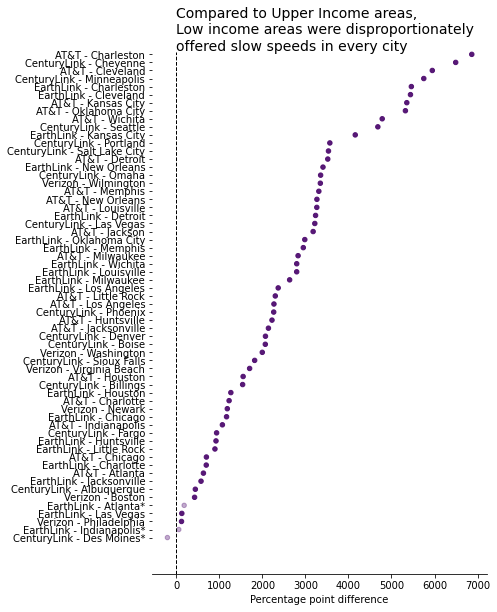

In [28]:
plot_observed(table, iv='income', fn=fn_observed_income,
              ylim=64.5,
              title = "Compared to Upper Income areas,\nLow income areas were disproportionately\noffered slow speeds in every city",)

8


<ipython-input-27-6f0b58a07f3e>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


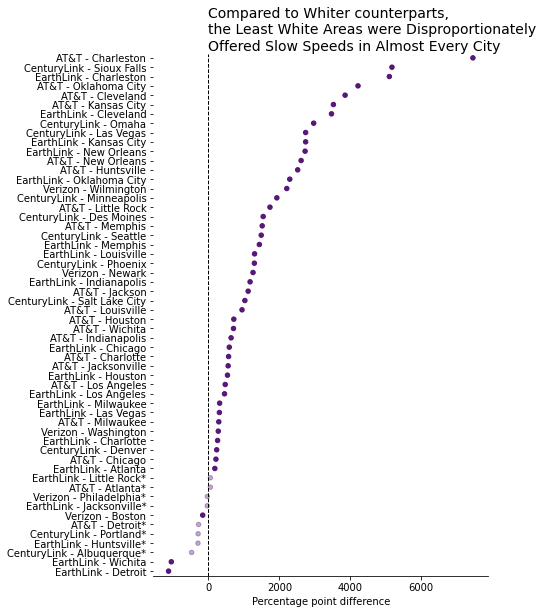

In [29]:
plot_observed(table, iv='race', fn=fn_observed_race, ylim=55.5,
              title = f"Compared to Whiter counterparts,\nthe Least White Areas were Disproportionately\nOffered Slow Speeds in Almost Every City")

0


<ipython-input-27-6f0b58a07f3e>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


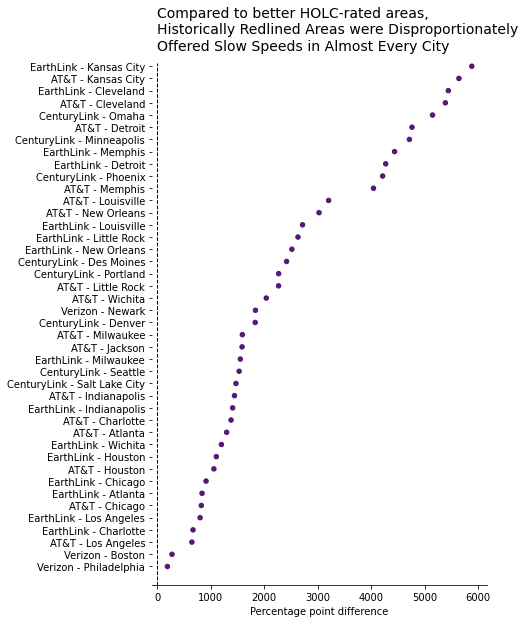

In [30]:
plot_observed(table, iv='redlining', fn=fn_observed_redlining, ylim=42.5,
              title = f"Compared to better HOLC-rated areas,\nHistorically Redlined Areas were Disproportionately\nOffered Slow Speeds in Almost Every City",
)

## Regression

In [31]:
def preprocess_for_log_reg(df):
    df['n_providers'] = df['n_providers'] - 1
    df['income_dollars_below_median'] = df['income_dollars_below_median'] / 100

    df['constant'] = 1
    scaler = StandardScaler()
    df['lat_standard'] = scaler.fit_transform(df[['lat']])[:, 0]
    scaler = StandardScaler()
    df['lon_standard'] = scaler.fit_transform(df[['lon']])[:, 0]
    scaler = StandardScaler()
    df['ppl_per_sq_mile_standard'] = scaler.fit_transform(df[['ppl_per_sq_mile']])[:, 0]
    scaler = StandardScaler()
    df['income_dollars_below_median'] = scaler.fit_transform(df[['income_dollars_below_median']])[:, 0]
    
    # if there are no competitors, make this variable null.
    # Then this variable is linked to the outcome.
    df.loc[df.n_providers < 1, 'internet_perc_broadband'] = None
    
    scaler = StandardScaler()
    df['internet_perc_broadband'] = scaler.fit_transform(df[['internet_perc_broadband']])[:, 0]

    # this is our DV
    df['is_slow'] = df.apply(
        lambda x: 1 if x['speed_down_bins'] == "Slow (<25 Mbps)" else 0, 
        axis=1
    )
    
    for iv in ['income_level', 'race_quantile', 'redlining_grade']:
        df[iv] = df[iv].apply(lambda x: grade2rest.get(x, x))
    return df  

In [32]:
def train_and_return_coefs(formula, df, city, isp, model_name):
    try:
        results = smf.logit(formula=formula, data=df).fit(disp=0)
        coefs = pd.DataFrame({
#             'variables': results.params.index,
            'coef': results.params.values,
            'odds_ratio': np.exp(results.params.values),
            'pvalue': results.pvalues,
            'pr_sq': results.prsquared,
            'N' : len(df),
            'major_city': city,
            'state' : df.state.iloc[0],
            'isp': isp,
            'model' : model_name,
            'intercept': results.params['Intercept'],
        })
    except Exception as e:
        coefs = pd.DataFrame([{
            'N' : len(df),
            'major_city': city,
            'state' : df.state.iloc[0],
            'isp': isp,
            'model' : model_name,
            'error': e
        }])
    
    return coefs

In [33]:
def odds_to_probability(row, step=1):
    """
    See about this equation here:
    http://faculty.cas.usf.edu/mbrannick/regression/Logistic.html
    """
    a = row['intercept']
    b = row['coef']
    X = step
    try:
        return math.exp(a + b * X) / (1 + math.exp(a + b * X))
    except:
        return None

In [34]:
iv2treatment = {
    "income_level" : 'Upper Income',
    "race_quantile" : 'most white',
    "redlining_grade" : 'rest'
}

grade2rest = {
    'A' : 'rest',
    'B' : 'rest',
}

In [35]:
if not os.path.exists(fn_regression_all) or recalculate:
    data_regression = pd.DataFrame([])
    
    args = []
    for isp, fn in inputs.items():
        df = filter_df(fn, isp)
        df['major_city'] = df['major_city'].apply(lambda x: x.title())
        for (city, state), _df in df.groupby(by=['major_city', 'state']):
            _df = bucket_and_bin(_df)
            _df = preprocess_for_log_reg(_df)
            
            n_slow = len(_df[_df.speed_down_bins == 'Slow (<25 Mbps)'])
            n_not_slow = len(_df[_df.speed_down_bins != 'Slow (<25 Mbps)'])
            n_all = len(_df)
            if (_df.speed_down_bins.nunique() <= 1) or (n_slow / n_all <= .01) or (n_not_slow / n_all <= .01):
                # not enough speed
                continue
            for iv, treatment in iv2treatment.items():
                if iv == 'race_quantile':
                    n_minority_white = len(_df[_df.race_perc_non_white > .5])            
                    # check only cities with at least 5 percent of addresses in minority white.
                    if n_minority_white / len(_df) <= .05:
                        print(f"skip {city} {isp}")
                        continue
                elif iv == 'redlining_grade':
                    _df_rated = _df[~_df.redlining_grade.isnull()]
                    if len(_df_rated) <= len(_df) * .05:
                        continue
                    if 'D' not in _df['redlining_grade'].unique().tolist():
                        continue
                formula = (f"is_slow ~ C({iv}, Treatment('{treatment}'))"
                            " + lat_standard + lon_standard + ppl_per_sq_mile_standard"
                            " + n_providers + internet_perc_broadband")

                args.append([formula, _df, city, isp, f"{iv}_controls"])

                # ablation formulas
                formulas = [" + ppl_per_sq_mile_standard" , " + n_providers ", 
                            " + internet_perc_broadband",
                            " + lat_standard + lon_standard"]
                for iv_ in formulas:
                    formula = f"is_slow ~ C({iv}, Treatment('{treatment}'))"
                    formula += "".join([f for f in formulas if f != iv_])
                    model_name =  f"{iv}_minus{iv_.replace(' + ', '_')}"
                    args.append([formula, _df, city, isp, model_name])

    with Pool(n_jobs) as pool:
        for coefs in tqdm(pool.istarmap(train_and_return_coefs, args), 
                           total=len(args)):
            data_regression = data_regression.append(coefs)

    # treatment group IE upper income, most white, best graded
    data_regression['probability_treatment'] = data_regression.apply(odds_to_probability, step=0, axis=1)
    # exposure group IE lower income, least white, redlined
    data_regression['probability_exposure'] = data_regression.apply(odds_to_probability, step=1, axis=1)
    data_regression['odds_directional'] = data_regression.apply(lambda x: x['odds_ratio'] * -1 if x['coef'] <0 else  x['odds_ratio'], axis=1)
    data_regression['is_coef_positive'] = data_regression.coef > 0
    # positive if exposure group has higher liklihood of slower speeds than treatment group
    data_regression['probability_delta'] = data_regression['probability_exposure'] - data_regression['probability_treatment']
    data_regression['perc_probability'] =  data_regression['probability_exposure'] / data_regression['probability_treatment']
    data_regression = data_regression[data_regression.index != 'Intercept']

    data_regression.to_csv(fn_regression_all)
    controls = data_regression[data_regression.model.str.contains('_controls')]
    controls.loc["C(income_level, Treatment('Upper Income'))[T.Low]"].to_csv(fn_regression_income)
    controls.loc["C(race_quantile, Treatment('most white'))[T.least white]"].to_csv(fn_regression_race)
    controls.loc["C(redlining_grade, Treatment('rest'))[T.D]"].to_csv(fn_regression_redlining)
    
else:
    data_regression = pd.read_csv(fn_regression_all, index_col=0)

In [36]:
len(set(data_regression[~data_regression.coef.isnull()].major_city.unique()))

41

## Ablation

In [37]:
# mean psuedo r-squared (goodness of fit) for each model across cities and ISPs.
for model, _df in data_regression.groupby(['model']):
    mean_pr = _df.groupby(['major_city', 'state', 'isp']).first().pr_sq.mean()
    print(model, mean_pr)

income_level_controls 0.12137358089371515
income_level_minus_internet_perc_broadband 0.11681491815004048
income_level_minus_lat_standard_lon_standard 0.0872258111057155
income_level_minus_n_providers  0.1177100678199145
income_level_minus_ppl_per_sq_mile_standard 0.10829888526602852
race_quantile_controls 0.10749300576634283
race_quantile_minus_internet_perc_broadband 0.09245748247710213
race_quantile_minus_lat_standard_lon_standard 0.07921241477543937
race_quantile_minus_n_providers  0.10543064207437881
race_quantile_minus_ppl_per_sq_mile_standard 0.09142144839149759
redlining_grade_controls 0.17617411592157894
redlining_grade_minus_internet_perc_broadband 0.15874376341057986
redlining_grade_minus_lat_standard_lon_standard 0.13414459207388651
redlining_grade_minus_n_providers  0.15644464717694995
redlining_grade_minus_ppl_per_sq_mile_standard 0.15598972601127153


The ablated IV that results in the least change from the observed are the most influential.

In [38]:
data_regression

,coef,odds_ratio,pvalue,pr_sq,N,major_city,state,isp,model,intercept,error,probability_treatment,probability_exposure,odds_directional,is_coef_positive,probability_delta,perc_probability
"C(income_level, Treatment('Upper Income'))[T.Low]",1.781588,5.939279,1.041469e-28,0.122143,10615,Atlanta,GA,AT&T,income_level_controls,-4.285032,NaN,0.013586,0.075617,5.939279,True,0.062031,5.565785
"C(income_level, Treatment('Upper Income'))[T.Moderate]",1.730545,5.643727,3.718838e-35,0.122143,10615,Atlanta,GA,AT&T,income_level_controls,-4.285032,NaN,0.013586,0.072126,5.643727,True,0.058540,5.308796
"C(income_level, Treatment('Upper Income'))[T.Middle]",0.498491,1.646236,4.550472e-07,0.122143,10615,Atlanta,GA,AT&T,income_level_controls,-4.285032,NaN,0.013586,0.022171,1.646236,True,0.008585,1.631908
lat_standard,0.257564,1.293774,1.369466e-08,0.122143,10615,Atlanta,GA,AT&T,income_level_controls,-4.285032,NaN,0.013586,0.017507,1.293774,True,0.003921,1.288631
lon_standard,0.140543,1.150898,1.389867e-03,0.122143,10615,Atlanta,GA,AT&T,income_level_controls,-4.285032,NaN,0.013586,0.015604,1.150898,True,0.002018,1.148544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"C(redlining_grade, Treatment('rest'))[T.C]",0.675234,1.964493,1.394860e-02,0.150008,10195,Wichita,KS,EarthLink,redlining_grade_minus_lat_standard_lon_standard,-4.233700,NaN,0.014291,0.027694,1.964493,True,0.013402,1.937782
"C(redlining_grade, Treatment('rest'))[T.D]",1.245390,3.474290,5.969842e-09,0.150008,10195,Wichita,KS,EarthLink,redlining_grade_minus_lat_standard_lon_standard,-4.233700,NaN,0.014291,0.047957,3.474290,True,0.033665,3.355631
ppl_per_sq_mile_standard,-0.970435,0.378918,1.166091e-22,0.150008,10195,Wichita,KS,EarthLink,redlining_grade_minus_lat_standard_lon_standard,-4.233700,NaN,0.014291,0.005464,-0.378918,False,-0.008828,0.382312
n_providers,0.981913,2.669558,3.058713e-11,0.150008,10195,Wichita,KS,EarthLink,redlining_grade_minus_lat_standard_lon_standard,-4.233700,NaN,0.014291,0.037263,2.669558,True,0.022971,2.607346


In [39]:
income_ablation = data_regression[
    (data_regression.pvalue < threshold) &
    (data_regression['model'].str.contains('income_level_minus_')) &
    (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
].merge(table, on=['isp', 'major_city', 'state'])
income_ablation['delta'] = abs(income_ablation['probability_delta'] - income_ablation['prop_slow_income_delta'])
income_ablation.sort_values(by='delta', ascending=True).groupby('major_city').first().model.value_counts(normalize=True)

income_level_minus_internet_perc_broadband      0.358974
income_level_minus_n_providers                  0.307692
income_level_minus_ppl_per_sq_mile_standard     0.230769
income_level_minus_lat_standard_lon_standard    0.102564
Name: model, dtype: float64

In [40]:
race_ablation = data_regression[
    (data_regression.pvalue < threshold) &
    (data_regression['model'].str.contains('race_quantile_minus_')) &
    (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
].merge(table, on=['isp', 'major_city', 'state'])
race_ablation['delta'] = abs(race_ablation['probability_delta'] - race_ablation['prop_slow_race_delta'])
race_ablation.sort_values(by='delta', ascending=True).groupby('major_city').first().model.value_counts(normalize=True)

race_quantile_minus_internet_perc_broadband      0.351351
race_quantile_minus_n_providers                  0.297297
race_quantile_minus_ppl_per_sq_mile_standard     0.243243
race_quantile_minus_lat_standard_lon_standard    0.108108
Name: model, dtype: float64

In [41]:
redlining_ablation = data_regression[
    (data_regression.pvalue < threshold) &
    (data_regression['model'].str.contains('redlining_grade_minus_')) &
    (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
].merge(table, on=['isp', 'major_city', 'state'])
redlining_ablation['delta'] = abs(redlining_ablation['probability_delta'] - redlining_ablation['prop_slow_redlining_delta'])
redlining_ablation.sort_values(by='delta', ascending=True).groupby('major_city').first().model.value_counts(normalize=True)

redlining_grade_minus_n_providers                  0.407407
redlining_grade_minus_internet_perc_broadband      0.222222
redlining_grade_minus_lat_standard_lon_standard    0.222222
redlining_grade_minus_ppl_per_sq_mile_standard     0.148148
Name: model, dtype: float64

## What's statistically significant after adjustments?

In [42]:
income = data_regression[(data_regression.model == f'income_level_controls') &
                         (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")].sort_values('coef', ascending=False)
race = data_regression[(data_regression.model == f'race_quantile_controls') &
                        (data_regression.index.isin(["C(race_quantile, Treatment('most white'))[T.least white]"]))].sort_values(['coef', 'state'], ascending=False)
redlining = data_regression[(data_regression.model == f'redlining_grade_controls') &
                (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")].sort_values('coef', ascending=False)

sig_income = income[income.pvalue < threshold]
slowest_income = sig_income[sig_income.probability_delta > 0]

sig_race = race[race.pvalue < threshold]
slowest_race = sig_race[sig_race.probability_delta > 0]

sig_redlining = redlining[redlining.pvalue < threshold]
slowest_redlining = sig_redlining[sig_redlining.probability_delta > 0]

print(f"Income significant in {len(sig_income) / len(income) * 100 :.1f}% ({len(sig_income)} out of {len(income)}) cases..."
     f"\n- low income areas recieve greater proprotion of slow speeds in {len(slowest_income) / len(sig_income) * 100:.1f}% of cases.\n")

print(f"Race significant in {len(sig_race) / len(race) * 100 :.1f}% ({len(sig_race)} out of {len(race)}) cases..."
     f"\n- least white areas recieve greater proportion of slow speeds in {len(slowest_race) / len(sig_race) * 100:.1f}% of cases.\n")

print(f"Redlining significant in {len(sig_redlining) / len(redlining) * 100 :.1f}% ({len(sig_redlining)} out of {len(redlining)}) cases..."
     f"\n- hazardous areas recieve greater proprotion of slow speeds in {len(slowest_redlining) / len(sig_redlining) * 100:.1f}% of cases.\n")

Income significant in 90.0% (54 out of 60) cases...
- low income areas recieve greater proprotion of slow speeds in 98.1% of cases.

Race significant in 83.9% (47 out of 56) cases...
- least white areas recieve greater proportion of slow speeds in 68.1% of cases.

Redlining significant in 87.5% (35 out of 40) cases...
- hazardous areas recieve greater proprotion of slow speeds in 94.3% of cases.



In [43]:
trend = set(sig_income.major_city.unique().tolist() + sig_race.major_city.unique().tolist() + sig_redlining.major_city.unique().tolist())

In [44]:
all_cities = set(income.major_city.unique().tolist() + race.major_city.unique().tolist() + redlining.major_city.unique().tolist())

In [45]:
cities = set(data_regression.major_city.unique())

In [46]:
len(all_cities)

40

In [47]:
cities_with_pattern - all_cities

{'Wilmington'}

In [48]:
data_regression[data_regression.major_city == 'Wilmington']

,coef,odds_ratio,pvalue,pr_sq,N,major_city,state,isp,model,intercept,error,probability_treatment,probability_exposure,odds_directional,is_coef_positive,probability_delta,perc_probability
0,NaN,NaN,NaN,NaN,825,Wilmington,DE,Verizon,income_level_controls,NaN,Singular matrix,NaN,NaN,NaN,False,NaN,NaN
0,NaN,NaN,NaN,NaN,825,Wilmington,DE,Verizon,income_level_minus_ppl_per_sq_mile_standard,NaN,Singular matrix,NaN,NaN,NaN,False,NaN,NaN
"C(income_level, Treatment('Upper Income'))[T.Low]",-0.347478,0.706468,8.197910e-01,0.452395,825,Wilmington,DE,Verizon,income_level_minus_n_providers,-2.756511,NaN,0.059720,0.042943,-0.706468,False,-0.016777,0.719073
"C(income_level, Treatment('Upper Income'))[T.Moderate]",-2.338508,0.096472,1.062995e-03,0.452395,825,Wilmington,DE,Verizon,income_level_minus_n_providers,-2.756511,NaN,0.059720,0.006090,-0.096472,False,-0.053630,0.101974
"C(income_level, Treatment('Upper Income'))[T.Middle]",-1.437772,0.237456,3.668472e-02,0.452395,825,Wilmington,DE,Verizon,income_level_minus_n_providers,-2.756511,NaN,0.059720,0.014857,-0.237456,False,-0.044862,0.248786
ppl_per_sq_mile_standard,-2.305062,0.099753,5.527604e-07,0.452395,825,Wilmington,DE,Verizon,income_level_minus_n_providers,-2.756511,NaN,0.059720,0.006296,-0.099753,False,-0.053424,0.105420
internet_perc_broadband,-0.255356,0.774641,4.355559e-01,0.452395,825,Wilmington,DE,Verizon,income_level_minus_n_providers,-2.756511,NaN,0.059720,0.046893,-0.774641,False,-0.012827,0.785208
lat_standard,-1.337981,0.262375,4.671556e-07,0.452395,825,Wilmington,DE,Verizon,income_level_minus_n_providers,-2.756511,NaN,0.059720,0.016391,-0.262375,False,-0.043329,0.274465
lon_standard,2.230472,9.304260,1.581061e-10,0.452395,825,Wilmington,DE,Verizon,income_level_minus_n_providers,-2.756511,NaN,0.059720,0.371441,9.304260,True,0.311721,6.219716
0,NaN,NaN,NaN,NaN,825,Wilmington,DE,Verizon,income_level_minus_internet_perc_broadband,NaN,Singular matrix,NaN,NaN,NaN,False,NaN,NaN


In [49]:
all_cities - trend

set()

## Plots with Adjustments

In [50]:
income = data_regression[
    (data_regression.model == f'income_level_controls') &
    (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
].sort_values('coef', ascending=False)

race = data_regression[
    (data_regression.model == f'race_quantile_controls') &
    (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
].sort_values(['coef', 'state'], ascending=False)

redline = data_regression[
    (data_regression.model == f'redlining_grade_controls') &
    (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
].sort_values('coef', ascending=False)

In [51]:
label2marker = {
    'Observed': 'o',
    'Adjusted': '^'
}

In [52]:
def plot_adjusted(to_plot, iv = 'redlining', ylim=33.5, figsize=(6, 8), fn=fn_adjusted_redlining,
                  title= f"After adjusting for other factors, Redlined areas\nstill disprportionately offered slow Internet speeds",
                  title_y = -3.2, title_x= -.05):
    legend_elements = [Line2D([0], [0], marker=label2marker.get(label), color='w', 
                          label=label, markerfacecolor=c, markersize=10)
                   for label, c in {'Observed': color_1, 'Adjusted': color_2}.items()][::-1] 
    
    to_plot_ = to_plot[(to_plot['pvalue'] < 0.05)]
    to_plot_['major_city_isp'] = to_plot_.apply(lambda x: x['isp'] + ' - ' + x['major_city'], axis=1)

    to_plot_['Observed'] = to_plot_[f'prop_slow_{iv}_delta'] * 100
    to_plot_['Adjusted'] = to_plot_.probability_delta * 100

    to_plot_ = to_plot_.sort_values(by=['Adjusted', 'state', 'Observed'], ascending=False)

    ax = to_plot_.plot(y='major_city_isp', x='Observed', 
                      color=color_1,
                      alpha = [bool2alpha.get(_) for _ in to_plot_.p_value_redlining < 0.05],
                      kind='scatter', figsize=figsize)
    to_plot_.plot(y='major_city_isp', x='Adjusted', 
                 color=color_2, ax=ax, marker='^',
                 alpha = [bool2alpha.get(_) for _ in to_plot_.pvalue < 0.05],
                 kind='scatter')

    x1 = to_plot_['Adjusted'].tolist()
    x2 = to_plot_['Observed'].tolist()
    n = to_plot_['major_city_isp'].tolist()
    for i in range(0, len(x1)):
        ax.plot([x1[i], x2[i]], [n[i], n[i]], '-', 
                color='black', zorder=-1, alpha=.8)

    to_plot_['isp'] = pd.Categorical(to_plot_['isp'], ["AT&T", "EarthLink", "CenturyLink", "Verizon"])
    to_plot_ = to_plot_.sort_values(by=['isp','Adjusted', 'state', 'Observed'], 
                                    ascending=[True, False, False, False])
    to_plot_[['major_city', 'isp', 'Adjusted', 'Observed', 'state']].to_csv(fn, index=False)    

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.gca().invert_yaxis()

    ax.set_ylabel("")
    labels = ax.get_xticks().tolist()
    labels = [int(_) for _ in labels]
    # labels[0] = "0%"
    ax.set_xticklabels(labels)
    ax.set_xlabel("Percentage point difference")
    # ax.get_legend().remove()

    plt.axvline(x=0,linewidth=1, color='black', linestyle='--', ymax=.96)

    plt.text(title_x, title_y, 
             title,
             size=14,
             horizontalalignment='left',
             verticalalignment='center',);
    ax.set_ylim(bottom=ylim)

    ax.legend(handles=legend_elements[::-1],
                  loc='lower left', 
                  bbox_to_anchor= (-0.025, .97), 
                  ncol=5,
                  handletextpad=0.0,
                  labelspacing=0, 
                  borderaxespad=.1, 
                  borderpad=0.1,
                  frameon=False,
                  prop={'size': 9.2})

<ipython-input-52-3e4f69fb4cc4>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


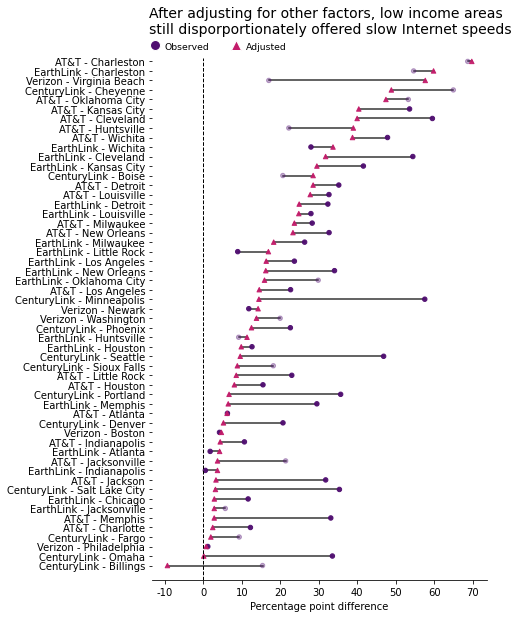

In [53]:
to_plot = income.merge(table, on=['major_city', 'state', 'isp'])
plot_adjusted(to_plot, iv='income', ylim=54.5, figsize=(6, 10), 
              fn=fn_adjusted_income,
              title_y = -4.2, title_x = -14, 
              title= f"After adjusting for other factors, low income areas\nstill disporportionately offered slow Internet speeds",
)

<ipython-input-52-3e4f69fb4cc4>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


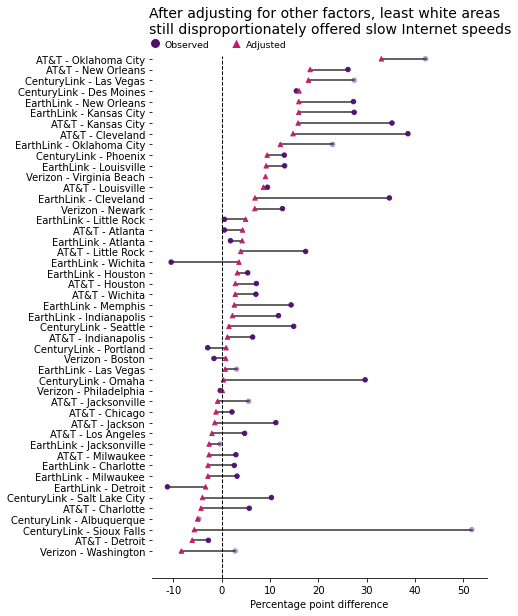

In [54]:
to_plot = race.merge(table, on=['major_city', 'state', 'isp'])
plot_adjusted(to_plot, iv='race', ylim=48.5, figsize=(6, 10), 
              fn=fn_adjusted_race,
              title_y = -3.5, title_x = -15,
              title= f"After adjusting for other factors, least white areas\nstill disproportionately offered slow Internet speeds",
)

<ipython-input-52-3e4f69fb4cc4>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


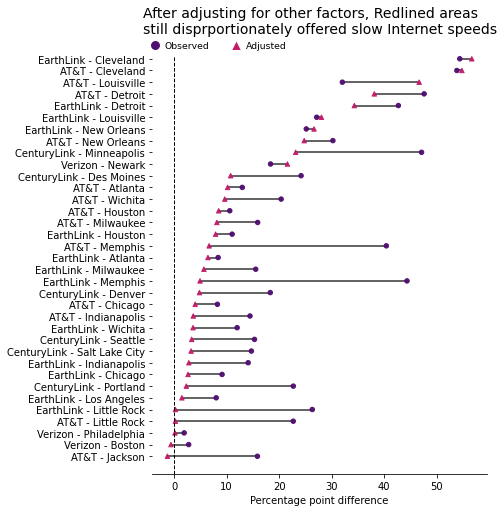

In [55]:
to_plot = redline.merge(table, on=['major_city', 'state', 'isp'])
plot_adjusted(to_plot, iv='redlining', title_y=-3.2, title_x=-6, ylim=35.5, fn=fn_adjusted_redlining)

In [56]:
to_plot[to_plot['major_city'] == 'Jackson'].iloc[0]

coef                                            -1.515435
odds_ratio                                       0.219713
pvalue                                           0.000013
pr_sq                                            0.434986
N                                                    3819
major_city                                        Jackson
state                                                  MS
isp                                                  AT&T
model                            redlining_grade_controls
intercept                                       -4.088001
error                                                 NaN
probability_treatment                            0.016496
probability_exposure                             0.003672
odds_directional                                -0.219713
is_coef_positive                                    False
probability_delta                               -0.012824
perc_probability                                 0.222578
slowest_income